# Workshop Tutorial: Estimators

In this tutorial, we'll cover the first stages of fitting a data set with PHOEBE, using the built-in estimator methods:

- lc_periodogram
- rv_periodogram
- ebai
- lc_geometry
- rv_geometry

These methods are meant to offer a kick-start to optimizing and bypass any significant amount of manual tweaking typically required for the user to get to an approximate solution.

This interactive workshop tutorial covers many of the same topics as the corresponding online tutorials:

* [Solving the Inverse Problem](http://phoebe-project.org/docs/2.3/tutorials/solver.ipynb)
* [Advanced: LC Estimators](http://phoebe-project.org/docs/2.3/tutorials/LC_estimators.ipynb)
* [Advanced: RV Geometry Estimator](http://phoebe-project.org/docs/2.3/tutorials/RV_estimators.ipynb)

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
logger = phoebe.logger('WARNING')
%matplotlib inline

For this tutorial and the upcoming fitting tutorials, we'll use a synthetic data set comprised of one light curve and radial velocity curves of the primary and secondary component. Let's load the data in our bundle and plot them first!

Fri, 02 Apr 2021 17:09 matplotlib.axes._axes WARNING *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


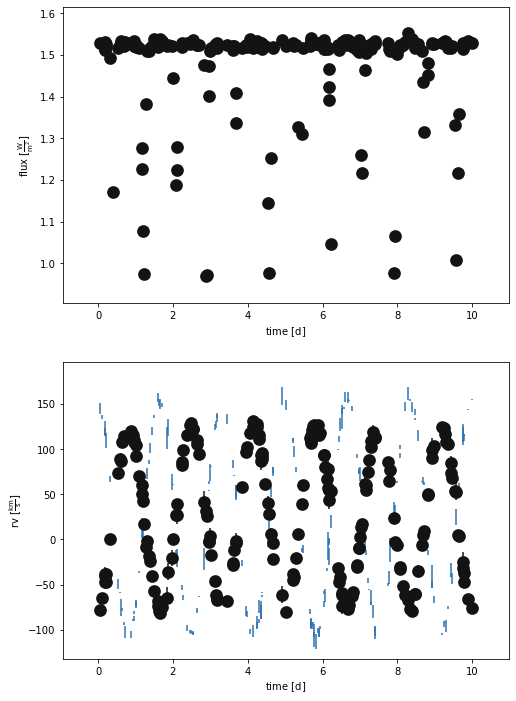

(<autofig.figure.Figure | 2 axes | 3 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [2]:
b = phoebe.default_binary()
# lc_tess = np.loadtxt('data/adra/photometry/tess_corrected_new.txt')
lc = np.loadtxt('data/synthetic/lc.data')
rv1 = np.loadtxt('data/synthetic/rv1.data')
rv2 = np.loadtxt('data/synthetic/rv2.data')

b.add_dataset('lc', times = lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')
b.add_dataset('rv')
b['times@rv@primary'], b['rvs@rv@primary'], b['sigmas@rv@primary'] = rv1[:,0], rv1[:,1], rv1[:,2]
b['times@rv@secondary'], b['rvs@rv@secondary'], b['sigmas@rv@secondary'] = rv2[:,0], rv2[:,1], rv2[:,2]
b.plot(x='times', show=True)

## Periodograms

PHOEBE offers both light curve and radial velocity curve periodograms. The light curve periodogram supports the box least-squares (BLS) algorithm, which is more suitable for "boxy" eclipses of detached stars, and Lomb-Scargle (LS), which is more suitable for stars with strong ellipsoidal variations. The radial velocity periodogram only supports the LS algorithm.

### rv_periodogram

Let's start with the rv_periodogram first:

In [3]:
b.add_solver('estimator.rv_periodogram', solver='rvperiod')
print(b['rvperiod'])

ParameterSet: 7 parameters
         comments@rvperiod@solver: 
        algorithm@rvperiod@solver: ls
      rv_datasets@rvperiod@solver: ['*']
        component@rvperiod@solver: binary
      sample_mode@rvperiod@solver: auto
   samples_per_peak@rvperiod@s...: 10
   nyquist_factor@rvperiod@solver: 5


We'll leave all the options to their default values for the time being and see what the output of the solver is.

In [4]:
b.run_solver('rvperiod', solution='rvperiod_solution')
print(b['rvperiod_solution'])

ParameterSet: 11 parameters
R  period@rvperiod_solution@so...: [ 0.40235315  0.41241198  0.42247081
 ... 40.01402079 40.02407961
 40.03413844] d
R  power@rvperiod_solution@sol...: [0.562767   0.55478154 0.55243615 ...
 0.71461299 0.71365716 0.70937088]
   period_factor@rvperiod_solu...: 1.0
R  fitted_uniqueids@rvperiod_s...: ['yqtWgzUOmBcfmPVZCkRMwNTuUalyax']
R  fitted_twigs@rvperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@rvperiod_solu...: [0.60352973]
R  fitted_units@rvperiod_solut...: ['d']
   adopt_parameters@rvperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@rvperio...: False
   adopt_values@rvperiod_solut...: True
   comments@rvperiod_solution@...: 


The first two lines of the output are the periods and respective powers that the automatic sampling mode has generated. We see that the chosen periods are in the range of 0.4~40, which may not be ideal for our case, where we can roughly estimate from the data that out period is 1-2 days. 

The period_factor can be adjusted by the user and determines if a multiple of the period is to be adopted, since the periodogram may land on a harmonic.

The rest of the output parameters refer to the solution and we can see that the fitted value of ~0.6 is not ideal. So let's instead provide manual samples in a narrower range.

In [5]:
b.set_value('sample_mode', context='solver', solver='rvperiod', value='manual')
b.set_value('sample_periods', context='solver', solver='rvperiod', value=np.linspace(0.5,5,1000))
b.run_solver('rvperiod', solution='rvperiod_solution_2')
print(b['rvperiod_solution_2'])

ParameterSet: 11 parameters
R  period@rvperiod_solution_2@...: [5.         4.9954955  4.99099099 ...
 0.50900901 0.5045045  0.5       ] d
R  power@rvperiod_solution_2@s...: [0.61138889 0.61152714 0.61166504 ...
 0.60717372 0.58970836 0.57461709]
   period_factor@rvperiod_solu...: 1.0
R  fitted_uniqueids@rvperiod_s...: ['yqtWgzUOmBcfmPVZCkRMwNTuUalyax']
R  fitted_twigs@rvperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@rvperiod_solu...: [1.67117117]
R  fitted_units@rvperiod_solut...: ['d']
   adopt_parameters@rvperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@rvperio...: False
   adopt_values@rvperiod_solut...: True
   comments@rvperiod_solution_...: 


The new value of the period ~1.67 looks much better now! Let's adopt it and plot our data in phase space to see the result.

Fri, 02 Apr 2021 17:09 BUNDLE       WARNING solution='rvperiod_solution_2' is not included in run_checks_solution@setting, so will not raise interactive warnings
Fri, 02 Apr 2021 17:09 matplotlib.axes._axes WARNING *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


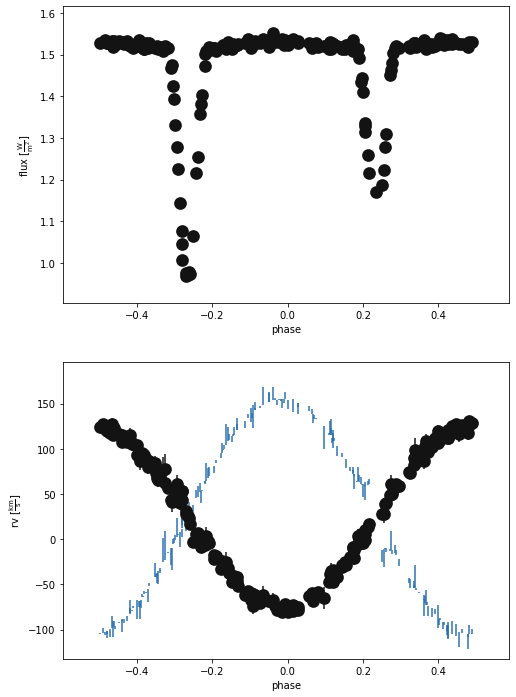

(<autofig.figure.Figure | 2 axes | 3 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [6]:
b.adopt_solution('rvperiod_solution_2')
b.plot(x='phase', show=True)

### lc_periodogram

The light curve periodogram follows a similar workflow as the rv_periodogram. Let's add two different ones and assign one of the two algorithm options to each.

In [7]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_bls', algorithm='bls')
b.add_solver('estimator.lc_periodogram', solver='lcperiod_ls', algorithm='ls')

<ParameterSet: 12 parameters | qualifiers: lc_combine, sample_periods, objective, minimum_n_cycles, nyquist_factor, samples_per_peak, duration, lc_datasets, algorithm, comments, component, sample_mode>

Not all parameters are applicable for both algorithms. For more details check: http://phoebe-project.org/docs/2.3/api/phoebe.parameters.solver.estimator.lc_periodogram

In [8]:
b.run_solver('lcperiod_bls', solution='lcperiod_bls_solution', overwrite=True)
print(b['fitted_values@lcperiod_bls_solution'])
b.run_solver('lcperiod_ls', solution='lcperiod_ls_solution', overwrite=True)
print(b['fitted_values@lcperiod_ls_solution'])

Parameter: fitted_values@lcperiod_bls@lcperiod_bls_solution@solution
                       Qualifier: fitted_values
                     Description: final values returned by the minimizer (in current default units of each parameter)
                           Value: [0.83426072]
                  Constrained by: 
                      Constrains: None
                      Related to: None

Parameter: fitted_values@lcperiod_ls@lcperiod_ls_solution@solution
                       Qualifier: fitted_values
                     Description: final values returned by the minimizer (in current default units of each parameter)
                           Value: [1.19700062]
                  Constrained by: 
                      Constrains: None
                      Related to: None



As expected, the bls algorithm performed better in our case, yielding half the period returned from the rv_periodogram. We can easily adopt the correct period by passing the period_factor in .adopt_solution():

Fri, 02 Apr 2021 17:09 BUNDLE       WARNING solution='lcperiod_bls_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Fri, 02 Apr 2021 17:09 matplotlib.axes._axes WARNING *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


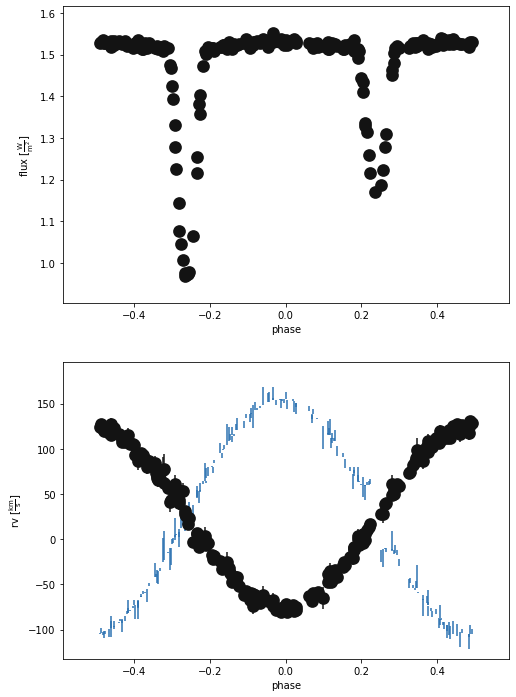

(<autofig.figure.Figure | 2 axes | 3 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [9]:
b.adopt_solution('lcperiod_bls_solution', period_factor=2)
b.plot(x='phase', show=True)

And now we have a period for our system straight from PHOEBE! 

## Parameter estimates from geometry

Before running the solvers, let's add and flip the required constraints and tweak some of the compute options, so that our computations run faster after adopting the solutions.

In [10]:
# ensures the model light curve is scaled to the data
b.set_value('pblum_mode', 'dataset-scaled')
# speeds up run_compute
b.set_value_all('distortion_method', 'sphere')
# avoids errors from atmospheres
b.set_value_all('atm', 'blackbody')
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual')

# useful constraints
b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')

# contraints that need to be flipped for lc_geometry
b.add_constraint('teffratio')
b.flip_constraint('teffratio', solve_for='teff@secondary')

# for rv_geometry
b.flip_constraint('asini@binary', solve_for='sma@binary')

# for EBAI
# b.flip_constraint('esinw', solve_for='ecc')
# b.flip_constraint('ecosw', solve_for='per0')

Fri, 02 Apr 2021 17:09 BUNDLE       WARNING ld_mode='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Fri, 02 Apr 2021 17:09 BUNDLE       WARNING ld_mode='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_mode@primary@rv01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Fri, 02 Apr 2021 17:09 BUNDLE       WARNING ld_mode='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_mode@primary@lc01.  If not addressed, this warning will continue to be raised and will throw an error at run_compute.
Fri, 02 Apr 2021 17:09 BUNDLE       WARNING ld_mode='interp' not supported by atm='blackbody'.  Either change atm@primary@phoebe01 or ld_mode@primary@rv01.  If not addressed, this warning will continue to be raised and will throw an er

<ConstraintParameter: {sma@binary@component} = {asini@binary@component} / (sin({incl@binary@component})) (solar units) => 5.3 solRad>

### rv_geometry

The rv_geometry solver provides simple estimates for several parameters that can be obtained from the radial velocity curves.

In [11]:
b.add_solver('estimator.rv_geometry', solver='rvgeom', overwrite=True)
b.run_solver('rvgeom', solution='rvgeom_solution')
for param, value, unit in zip(b['value@fitted_twigs@rvgeom_solution'],
                       b['value@fitted_values@rvgeom_solution'],
                        b['value@fitted_units@rvgeom_solution']     ):
    print('%s = %.2f %s' % (param,value,unit))

t0_supconj@binary@orbit@component = -0.44 d
q@binary@orbit@component = 0.80 
asini@binary@orbit@component = 5571435.78 km
ecc@binary@orbit@component = 0.01 
per0@binary@orbit@component = 3.83 rad
vgamma@system = 25.07 km / s


Fri, 02 Apr 2021 17:09 BUNDLE       WARNING solution='rvgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Fri, 02 Apr 2021 17:09 PARAMETERS   WARNING wrapping value of mean_anom to 326.48665036071066 deg
100%|██████████| 200/200 [00:06<00:00, 30.05it/s]
Fri, 02 Apr 2021 17:10 matplotlib.axes._axes WARNING *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


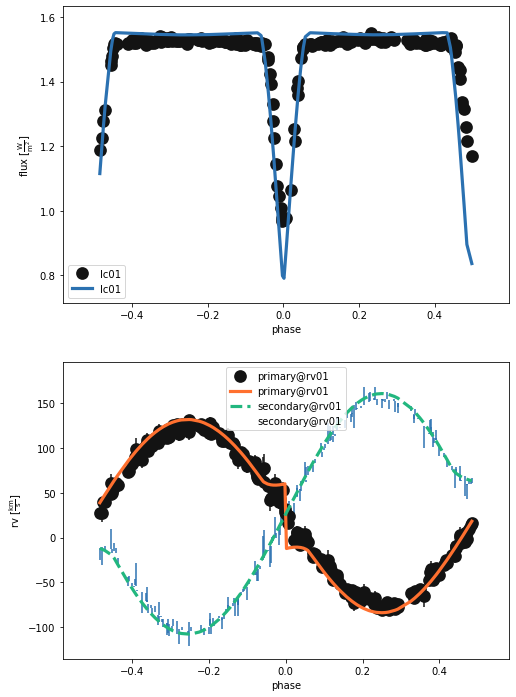

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [12]:
b.adopt_solution('rvgeom_solution')
b.run_compute(model='rvgeom_model')
b.plot(x='phase', legend=True, show=True)

### EBAI

The EBAI (Eclipsing Binaries Aritifical Intelligence) estimator relies on a trained neural network to return estimates of the sum of radii, inclination, temperature ratio, esinw and ecosw from the light curve.

Now we're ready to add and run EBAI:

In [13]:
b.add_solver('estimator.ebai', solver='ebai_est')
b.run_solver('ebai_est', solution='ebai_solution')

# cleaner output
for param, value, unit in zip(b['value@fitted_twigs@ebai_solution'],
                       b['value@fitted_values@ebai_solution'],
                        b['value@fitted_units@ebai_solution']     ):
    print('%s = %.2f %s' % (param,value,unit))

t0_supconj@binary@orbit@component = -0.44 d
teffratio@binary@orbit@component = 0.82 
requivsumfrac@binary@orbit@component = 0.35 
esinw@binary@orbit@component = 0.02 
ecosw@binary@orbit@component = -0.06 
incl@binary@orbit@component = 1.48 rad


Fri, 02 Apr 2021 17:10 PARAMETERS   WARNING wrapping value of per0 to 219.4713649566367 deg
Fri, 02 Apr 2021 17:10 BUNDLE       WARNING solution='ebai_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Fri, 02 Apr 2021 17:10 PARAMETERS   WARNING wrapping value of mean_anom to 327.3068910923128 deg
100%|██████████| 200/200 [00:06<00:00, 31.17it/s]
Fri, 02 Apr 2021 17:10 matplotlib.axes._axes WARNING *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


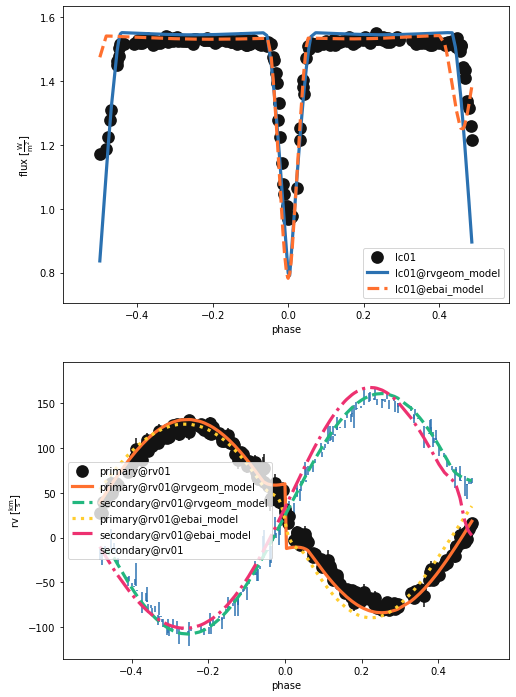

(<autofig.figure.Figure | 2 axes | 9 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [14]:
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

b.adopt_solution('ebai_solution')
b.run_compute(model='ebai_model')
b.plot(x='phase', legend=True, show=True)

We can see that EBAI is not particularly good at estimating esinw and ecosw. Luckily, we can use lc_geometry to improve on those particular values:

In [15]:
b.add_solver('estimator.lc_geometry', solver='lcgeom')
b.run_solver('lcgeom', solution='lcgeom_solution')

for param, value, unit in zip(b['value@fitted_twigs@lcgeom_solution'][:3],
                       b['value@fitted_values@lcgeom_solution'][:3],
                        b['value@fitted_units@lcgeom_solution'][:3]):
    print('%s = %.2f %s' % (param,value,unit))

/Users/angela/miniconda3/lib/python3.8/site-packages/phoebe/parameters/parameters.py:10093: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


t0_supconj@binary@orbit@component = 1.23 d
ecc@binary@orbit@component = 0.01 
per0@binary@orbit@component = 1.58 rad


Fri, 02 Apr 2021 17:10 BUNDLE       WARNING solution='lcgeom_solution' is not included in run_checks_solution@setting, so will not raise interactive warnings
Fri, 02 Apr 2021 17:10 PARAMETERS   WARNING wrapping value of mean_anom to 93.56591187383401 deg
100%|██████████| 200/200 [00:06<00:00, 31.11it/s]
Fri, 02 Apr 2021 17:10 matplotlib.axes._axes WARNING *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


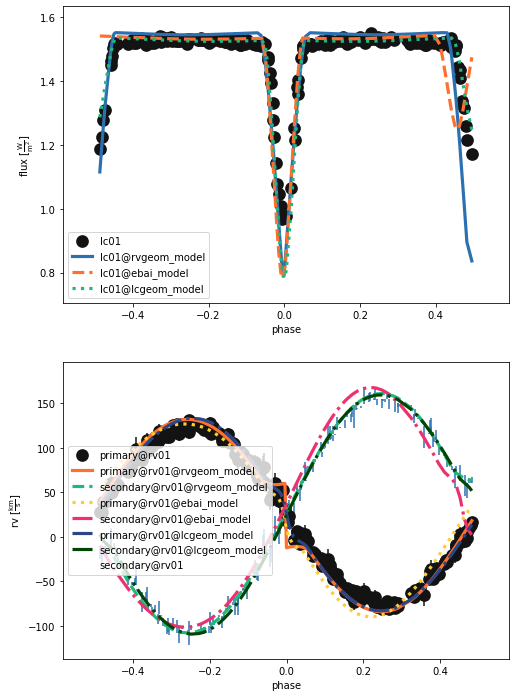

(<autofig.figure.Figure | 2 axes | 12 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [16]:
b.flip_constraint('ecc', solve_for='esinw')
b.flip_constraint('per0', solve_for='ecosw')
b.adopt_solution('lcgeom_solution')
b.run_compute(model='lcgeom_model')
b.plot(x='phase', legend=True, show=True)

Finally, let's return the atmosphere parameters to their default PHOEBE values and ensure that our solution is within the atmosphere table bounds. (Moving forward to optimiziers and samplers, we want to make sure that we're starting from a somewhat physical solution!)

100%|██████████| 200/200 [00:06<00:00, 29.36it/s]
Fri, 02 Apr 2021 17:10 matplotlib.axes._axes WARNING *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


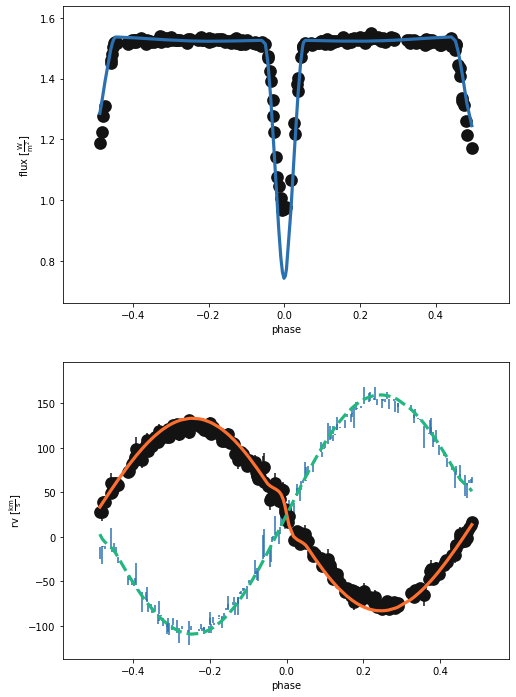

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [17]:
b.set_value_all('atm', 'ck2004')
b.set_value_all('ld_mode', 'interp')
b.set_value_all('ld_mode_bol', 'lookup')
b.run_compute()
b.plot(['dataset', 'latest'], x='phase', show=True)

In [18]:
b.save('data/synthetic/after_estimators.bundle')

'data/synthetic/after_estimators.bundle'

# Exercises

1. Initialize a new bundle and load the synthetic light curve used in the tutorial. Add a light curve periodogram and try to tweak the parameter values, such that the periodogram will yield the true period, instead of the half-value harmonic.

2. Initialize a new bundle. Load only the primary radial velocity data. Set the period to 1.67 and t0 to 1.23. Add an rv_geometry estimatator and examine how the output is different compared to the output in the tutorial, where we had both RVs.